In [52]:
# Import libaries
import re
import importlib


In [53]:
# Libary to import self-made libaries
import sys # https://stackoverflow.com/questions/4383571/importing-files-from-different-folder
sys.path.insert(1, r'C:\Users\ruw\Desktop\RA\Single-use-vs-multi-use-in-health-care\Brighway\Libaries')

In [54]:
# Importing self-made libaries
import standards as s
import Monte_Carlo as MC
import life_cycle_assessment as lc
import LCA_plots as lp
import box_plot as bp
import LCIA_calculation as calc

# Reload to reset the state of the self-made libaries
# https://dev.to/fronkan/importlib-reload-for-resting-modules-between-tests-neh
importlib.reload(s)
importlib.reload(MC)
importlib.reload(lc)
importlib.reload(lp)
importlib.reload(bp)

<module 'box_plot' from 'C:\\Users\\ruw\\Desktop\\RA\\Single-use-vs-multi-use-in-health-care\\Brighway\\Libaries\\box_plot.py'>

In [55]:
# Specifying if it is CONSQ (consequential) or APOS
db_type = 'APOS'

# Specifying the LCIA method
lcia_method = 'recipe'


In [56]:
# Path to where the code is stored
path = r'C:\Users\ruw\Desktop\RA\Single-use-vs-multi-use-in-health-care\Brighway'

file_identifier = 'Ananas'
res_folder_identifier = 'Ofir'

# Specifying the file name and sheet name
file_name = f'{path}\Results\{file_identifier} - {db_type}_{lcia_method}.xlsx'
sheet_name = f'{file_identifier}'

# Creating the saving directory for the results
save_dir = s.results_folder(path, 'Results', res_folder_identifier)

# Let the use decide the project and database
database_project, database_name = lc.select_project_and_database()

# Creating the flow legend
flow_legend = ['H2R',
               'H2S',
               'ASC',
               'ASW',
               'H4R',
               'H4S',
               'ALC',
               'ALW'
               ]

Folder name Results created
The chosen project is SU_vs_MU and the chosen database is sterilization


In [57]:
flows = lc.get_database_type_flows(database_project, database_name, db_type)
flows

['H200 REC - APOS',
 'H200 SU - APOS',
 'H400 REC - APOS',
 'H400 SU - APOS',
 'alubox large + washer - APOS',
 'alubox large + wipe - APOS',
 'alubox small + washer - APOS',
 'alubox small + wipe - APOS']

In [58]:
# flows = lc.get_user_specific_flows(database_project, database_name)
# flows

In [59]:
initialization = [database_project, database_name, flows, lcia_method, db_type]
file_name_unique = f'{path}\Results\{file_identifier} - {db_type}_{lcia_method}_unq.xlsx'

In [60]:
# df, plot_x_axis_all, impact_categories = calc.quick_LCIA(initialization, file_name, file_name_unique, sheet_name, num_cores=4)

In [61]:
df, plot_x_axis_all, impact_categories = lc.quick_LCIA(initialization, file_name, file_name_unique, sheet_name)

Recipe is selected
Initialization is completed
DataFrame with nested lists written to Excel successfully.


In [62]:
df_rearranged = lc.rearrange_dataframe_index(df)

In [63]:
# if calculate_cont == True:
#     sub_proccess, amount = lc.obtaining_sub_process(sub_product_details)
#     FU_sub, FU_sub_process, idx = lc.sub_process_initilization(sub_proccess, FU, database_project, f'df_idx_ofir_{db_type}', lcia_method, db_type)
#     flow_count, flow_sub, functional_unit_sub = lc.FU_contibution_initilization(FU_sub, FU_sub_process)
#     fu_sub_updated = lc.process_update(FU, functional_unit_sub)
    
#     df_cont = lc.LCIA_contribution(impact_category[1], flow_count, FU_sub_process, fu_sub_updated, amount, idx)
#     lc.save_LCA_results(df_cont, file_cont_name, sheet_name, impact_category)
#     df_c = lc.import_LCA_results(file_cont_name, idx, impact_category[1])


In [64]:
if 'recipe' in lcia_method:
    df_res, df_endpoint = lc.recipe_dataframe_split(df_rearranged)
    plot_x_axis_end = plot_x_axis_all[-3:]
    ic_mid = plot_x_axis_all[:-3] 
    plot_x_axis = []
    for ic in ic_mid:
        # print(ic)
        string = re.findall(r'\((.*?)\)', ic)
        if 'ODPinfinite' in  string[0]:
            string[0] = 'ODP'
        elif '1000' in string[0]:
            string[0] = 'GWP'
        plot_x_axis.append(string[0])

else:
    df_res = df_rearranged
    plot_x_axis = plot_x_axis_all

In [86]:
df_res

,"(ReCiPe 2016 v1.03, midpoint (H), acidification: terrestrial, terrestrial acidification potential (TAP))","(ReCiPe 2016 v1.03, midpoint (H), climate change, global warming potential (GWP1000))","(ReCiPe 2016 v1.03, midpoint (H), ecotoxicity: freshwater, freshwater ecotoxicity potential (FETP))","(ReCiPe 2016 v1.03, midpoint (H), ecotoxicity: marine, marine ecotoxicity potential (METP))","(ReCiPe 2016 v1.03, midpoint (H), ecotoxicity: terrestrial, terrestrial ecotoxicity potential (TETP))","(ReCiPe 2016 v1.03, midpoint (H), energy resources: non-renewable, fossil, fossil fuel potential (FFP))","(ReCiPe 2016 v1.03, midpoint (H), eutrophication: freshwater, freshwater eutrophication potential (FEP))","(ReCiPe 2016 v1.03, midpoint (H), eutrophication: marine, marine eutrophication potential (MEP))","(ReCiPe 2016 v1.03, midpoint (H), human toxicity: carcinogenic, human toxicity potential (HTPc))","(ReCiPe 2016 v1.03, midpoint (H), human toxicity: non-carcinogenic, human toxicity potential (HTPnc))","(ReCiPe 2016 v1.03, midpoint (H), ionising radiation, ionising radiation potential (IRP))","(ReCiPe 2016 v1.03, midpoint (H), land use, agricultural land occupation (LOP))","(ReCiPe 2016 v1.03, midpoint (H), material resources: metals/minerals, surplus ore potential (SOP))","(ReCiPe 2016 v1.03, midpoint (H), ozone depletion, ozone depletion potential (ODPinfinite))","(ReCiPe 2016 v1.03, midpoint (H), particulate matter formation, particulate matter formation potential (PMFP))","(ReCiPe 2016 v1.03, midpoint (H), photochemical oxidant formation: human health, photochemical oxidant formation potential: humans (HOFP))","(ReCiPe 2016 v1.03, midpoint (H), photochemical oxidant formation: terrestrial ecosystems, photochemical oxidant formation potential: ecosystems (EOFP))","(ReCiPe 2016 v1.03, midpoint (H), water use, water consumption potential (WCP))"
H200 REC - APOS,"[['market for polypropylene, granulate' (kilog...","[['market for polypropylene, granulate' (kilog...","[['market for polypropylene, granulate' (kilog...","[['market for polypropylene, granulate' (kilog...","[['market for polypropylene, granulate' (kilog...","[['market for polypropylene, granulate' (kilog...","[['market for polypropylene, granulate' (kilog...","[['market for polypropylene, granulate' (kilog...","[['market for polypropylene, granulate' (kilog...","[['market for polypropylene, granulate' (kilog...","[['market for polypropylene, granulate' (kilog...","[['market for polypropylene, granulate' (kilog...","[['market for polypropylene, granulate' (kilog...","[['market for polypropylene, granulate' (kilog...","[['market for polypropylene, granulate' (kilog...","[['market for polypropylene, granulate' (kilog...","[['market for polypropylene, granulate' (kilog...","[['market for polypropylene, granulate' (kilog..."
H200 SU - APOS,"[['market for polypropylene, granulate' (kilog...","[['market for polypropylene, granulate' (kilog...","[['market for polypropylene, granulate' (kilog...","[['market for polypropylene, granulate' (kilog...","[['market for polypropylene, granulate' (kilog...","[['market for polypropylene, granulate' (kilog...","[['market for polypropylene, granulate' (kilog...","[['market for polypropylene, granulate' (kilog...","[['market for polypropylene, granulate' (kilog...","[['market for polypropylene, granulate' (kilog...","[['market for polypropylene, granulate' (kilog...","[['market for polypropylene, granulate' (kilog...","[['market for polypropylene, granulate' (kilog...","[['market for polypropylene, granulate' (kilog...","[['market for polypropylene, granulate' (kilog...","[['market for polypropylene, granulate' (kilog...","[['market for polypropylene, granulate' (kilog...","[['market for polypropylene, granulate' (kilog..."
alubox small + washer - APOS,"[['alubox raw materials - APOS' (kilogram, GLO...","[['alubox raw materials - APOS' (kilogram, GLO...","[['alubox raw materials - APOS' (kilogram, GLO...","[['alubox raw materials - APOS' (kilogr

In [65]:
df_tot, df_scaled = lc.dataframe_element_scaling(df_res)
df_col = [df_res.columns[1]]
df_GWP = df_res[df_col]

unique_elements = lc.unique_elements_list(database_name)
colors = s.plot_colors(unique_elements,'turbo')

inputs = [flow_legend, colors, save_dir, db_type, database_name]

In [85]:
df_tot

,"(ReCiPe 2016 v1.03, midpoint (H), acidification: terrestrial, terrestrial acidification potential (TAP))","(ReCiPe 2016 v1.03, midpoint (H), climate change, global warming potential (GWP1000))","(ReCiPe 2016 v1.03, midpoint (H), ecotoxicity: freshwater, freshwater ecotoxicity potential (FETP))","(ReCiPe 2016 v1.03, midpoint (H), ecotoxicity: marine, marine ecotoxicity potential (METP))","(ReCiPe 2016 v1.03, midpoint (H), ecotoxicity: terrestrial, terrestrial ecotoxicity potential (TETP))","(ReCiPe 2016 v1.03, midpoint (H), energy resources: non-renewable, fossil, fossil fuel potential (FFP))","(ReCiPe 2016 v1.03, midpoint (H), eutrophication: freshwater, freshwater eutrophication potential (FEP))","(ReCiPe 2016 v1.03, midpoint (H), eutrophication: marine, marine eutrophication potential (MEP))","(ReCiPe 2016 v1.03, midpoint (H), human toxicity: carcinogenic, human toxicity potential (HTPc))","(ReCiPe 2016 v1.03, midpoint (H), human toxicity: non-carcinogenic, human toxicity potential (HTPnc))","(ReCiPe 2016 v1.03, midpoint (H), ionising radiation, ionising radiation potential (IRP))","(ReCiPe 2016 v1.03, midpoint (H), land use, agricultural land occupation (LOP))","(ReCiPe 2016 v1.03, midpoint (H), material resources: metals/minerals, surplus ore potential (SOP))","(ReCiPe 2016 v1.03, midpoint (H), ozone depletion, ozone depletion potential (ODPinfinite))","(ReCiPe 2016 v1.03, midpoint (H), particulate matter formation, particulate matter formation potential (PMFP))","(ReCiPe 2016 v1.03, midpoint (H), photochemical oxidant formation: human health, photochemical oxidant formation potential: humans (HOFP))","(ReCiPe 2016 v1.03, midpoint (H), photochemical oxidant formation: terrestrial ecosystems, photochemical oxidant formation potential: ecosystems (EOFP))","(ReCiPe 2016 v1.03, midpoint (H), water use, water consumption potential (WCP))"
H200 REC - APOS,0.002031,1.418327,0.190721,0.250506,2.34043,0.246931,0.000383,0.000543,0.077582,3.934863,0.097573,0.005697,0.010777,0.0,0.000812,0.001415,0.001485,0.011732
H200 SU - APOS,0.002108,1.432497,0.195647,0.257828,2.609692,0.295685,0.000381,0.000542,0.078356,3.979997,0.092131,-0.024449,0.011194,0.0,0.000833,0.001431,0.001507,0.012076
alubox small + washer - APOS,0.00314,2.145901,0.285551,0.374123,2.753995,0.294535,0.000585,0.000807,0.136985,5.985113,0.143202,0.045679,0.016764,0.000001,0.001247,0.002108,0.002197,0.017448
alubox small + wipe - APOS,0.003039,1.915604,0.249784,0.327058,2.528012,0.279189,0.000533,0.000807,0.123892,5.2252,0.128703,0.050475,0.015133,0.000001,0.001174,0.002678,0.003205,0.024737
H400 REC - APOS,0.003222,2.039687,0.2663,0.350851,3.92157,0.436159,0.000541,0.000744,0.10961,5.411248,0.134011,-0.026841,0.015941,0.000001,0.001324,0.002261,0.002379,0.01726
H400 SU - APOS,0.003441,2.082415,0.280462,0.371893,4.696341,0.574954,0.000535,0.000744,0.111872,5.541722,0.118606,-0.112587,0.017136,0.000001,0.001384,0.002307,0.002444,0.018243
alubox large + washer - APOS,0.004955,3.363223,0.447828,0.586766,4.293947,0.460882,0.000913,0.001259,0.216404,9.385267,0.221034,0.07151,0.026373,0.000001,0.001972,0.003319,0.003459,0.027388
alubox large + wipe - APOS,0.00457,2.894723,0.37455,0.490531,3.748133,0.418311,0.000806,0.001165,0.190562,7.84673,0.196183,0.07113,0.023014,0.000001,0.001788,0.0037,0.004268,0.032662


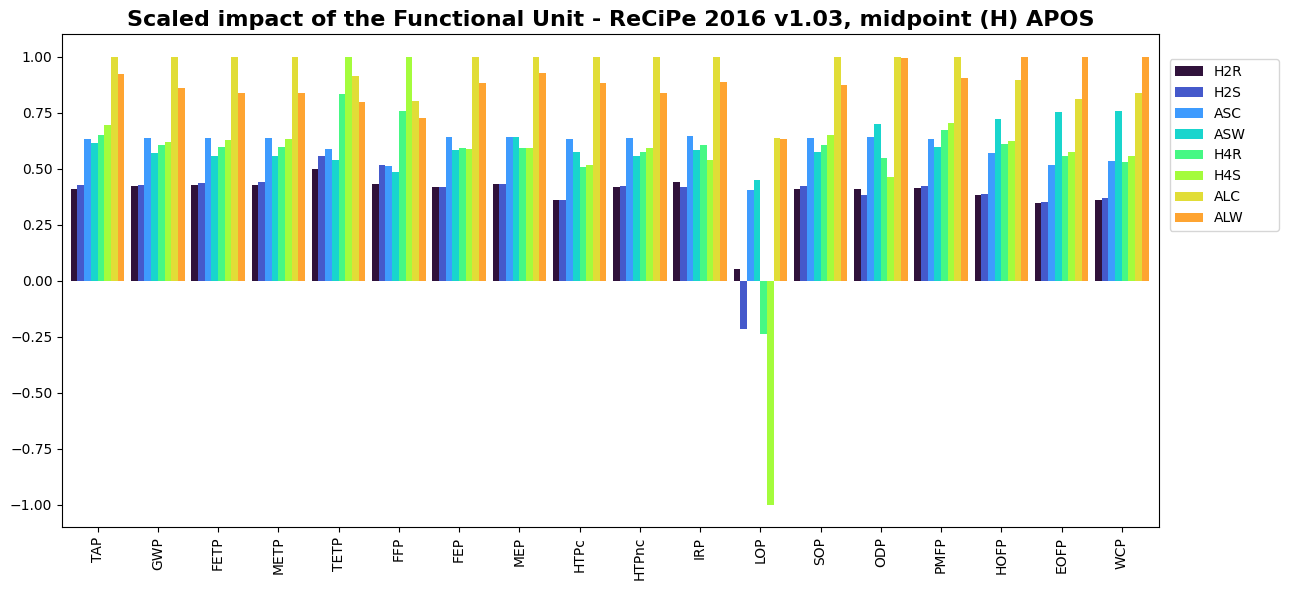

In [66]:
leg_pos_mid = .601

lp.scaled_FU_plot(df_scaled, plot_x_axis, inputs, impact_categories, leg_pos_mid)

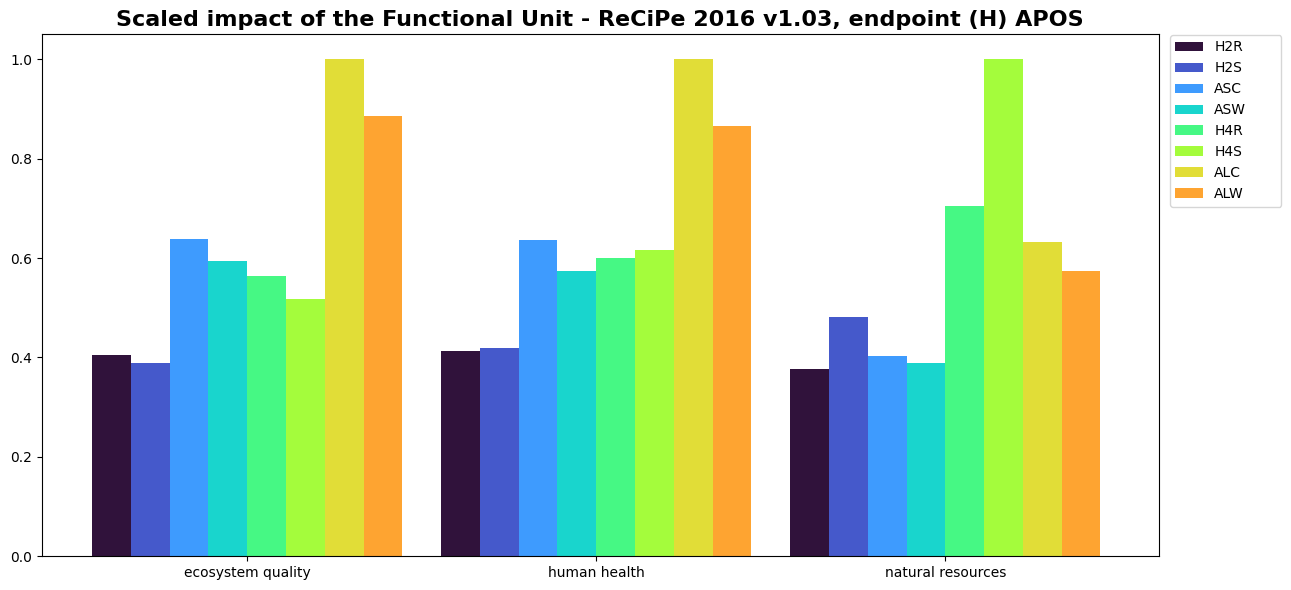

In [67]:
leg_pos_end = 0.67
if 'recipe' in lcia_method.lower():
    df_tot_e, df_scaled_e = lc.dataframe_element_scaling(df_endpoint)
    lp.scaled_FU_plot(df_scaled_e, plot_x_axis_end, inputs, impact_categories[-3:], leg_pos_end)


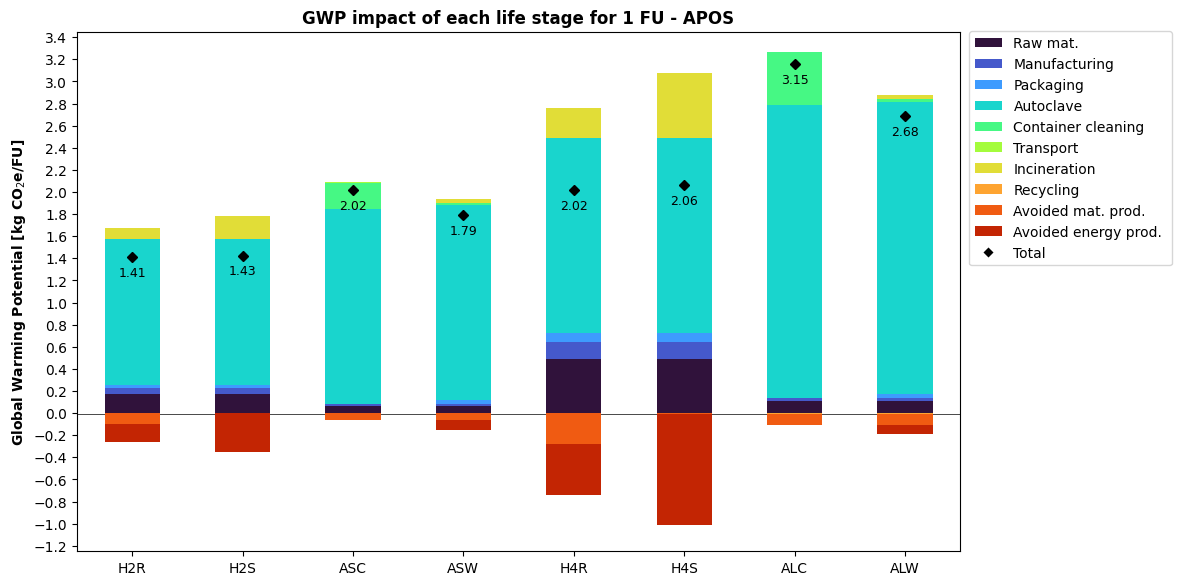

In [80]:
y_min = -1.2
y_max = 3.4
step = 0.2
leg_pos = 0.55
marker_offset = 0.2
y_axis_values = [y_min, y_max, step, leg_pos, marker_offset]
lp.gwp_scenario_plot(df_GWP, inputs, y_axis_values)


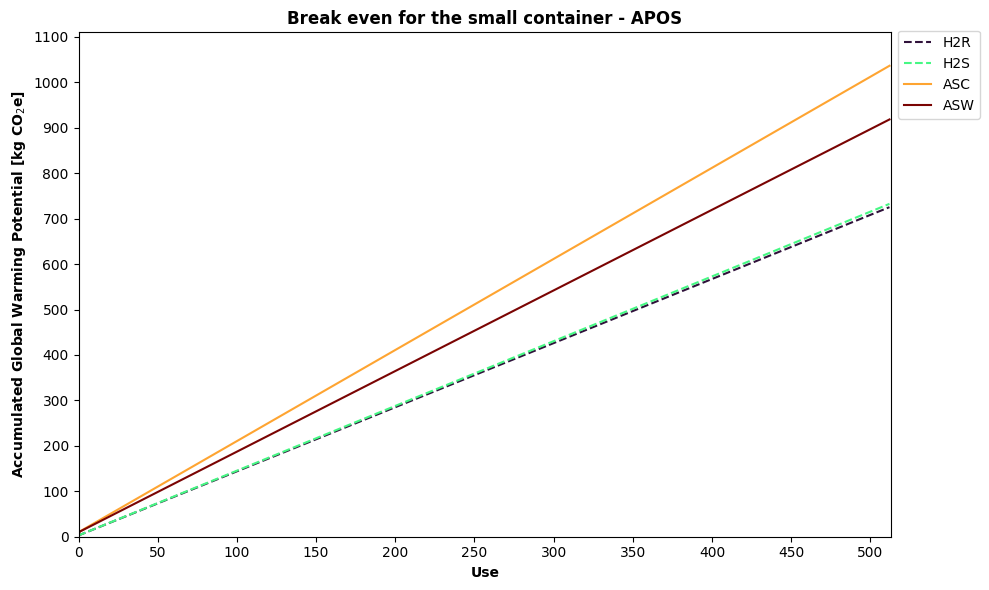

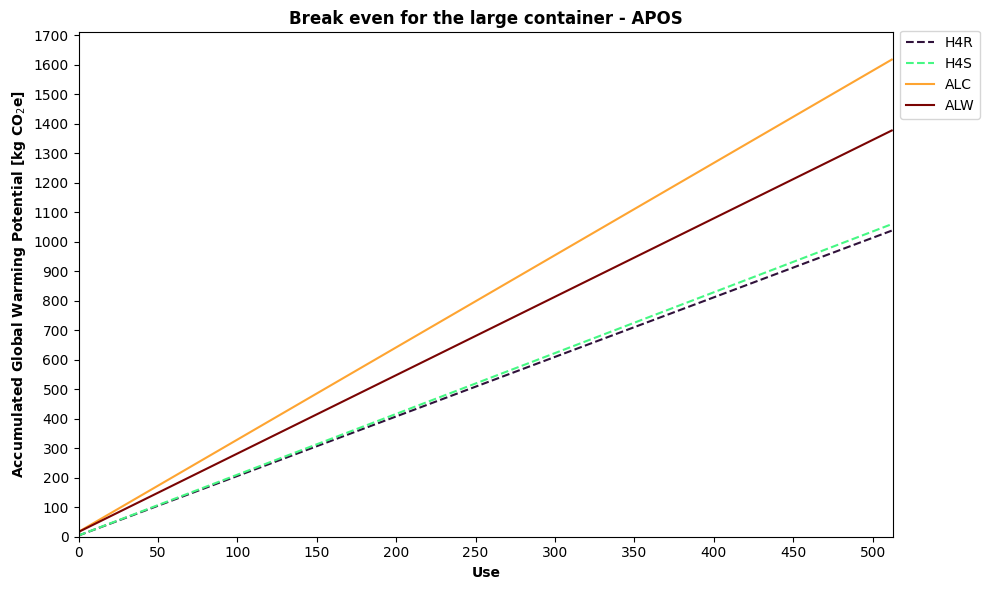

In [84]:
amount_of_uses = 513
y_max = [1100, 1700]
ystep = [100, 100]
xstep = 50
break_even_product = 'container'
color_idx = [0, 4, 7, 10]

plot_controls = [amount_of_uses, y_max, ystep, xstep, break_even_product, color_idx]
lp.break_even_graph(df_GWP, inputs, plot_controls)

In [ ]:
import pandas as pd
from copy import deepcopy as dc


file = f'{path}Single-use-vs-multi-use-in-health-care\\Norm + Weigh.xlsx'
data_NW = pd.read_excel(file)
columns = df_tot.columns

norm_lst = data_NW['Normalization'].tolist()
weigh_lst = data_NW['Weighting'].tolist()

df_simon = pd.read_excel(r'C:\Users\ruw\Desktop\RA\Single-use-vs-multi-use-in-health-care\Brighway\all comparison.xlsx', sheet_name='data')
df_simon = df_simon[df_simon.columns[1:]]


weigh_df = dc(df_simon)
cols_to_iter = df_simon.columns[6:]
data_cols = df_simon.columns[:6].to_list()
data_cols
ic = lc.lcia_method('ef')
ic = [str(i).replace(f' EN15804', '') for i in ic ]
new_cols = data_cols + ic
df_new = pd.DataFrame(0, index=df_simon.index,columns=new_cols, dtype=object)



for col in df_new.columns:
    col_str = str(col)
    for idx, row in df_new.iterrows():
        row[col] = df_simon.at[idx, col_str]   

    
weigh_df = dc(df_new)
norm_df = dc(df_new)

for col_idx, col in enumerate(ic):
    # print(col)
    for row_idx, row in norm_df.iterrows():
        row[col] =  df_new.at[row_idx, col] * norm_lst[col_idx]

for col_idx, col in enumerate(ic):
    # print(col)
    for row_idx, row in weigh_df.iterrows():
        row[col] =  norm_df.at[row_idx, col] * weigh_lst[col_idx]
    
sc_col = data_cols
if sc_col[-1] != 'single score':
    sc_col.append('single score')

sc_col

single_score_df = pd.DataFrame(0, index=df_simon.index, columns=sc_col, dtype=object)

for col in df_new.columns:
    col_str = str(col)
    for idx, row in single_score_df.iterrows():
        try:
            row[col] = df_simon.at[idx, col_str] 
        except ValueError:
            pass

for idx_val, row in weigh_df.iterrows():
    temp = 0
    for i in ic:
        temp += row[i]
    # print(weigh_df['Database'][a])
    single_score_df.at[idx_val, 'single score'] = temp


simon = r'C:\Users\ruw\Desktop\RA\Single-use-vs-multi-use-in-health-care\Brighway\all comparison.xlsx'
writer = pd.ExcelWriter(simon, engine = 'xlsxwriter')
df_simon.to_excel(writer, sheet_name = 'data')
norm_df.to_excel(writer, sheet_name = 'normalized')
weigh_df.to_excel(writer, sheet_name = 'weighted')
single_score_df.to_excel(writer, sheet_name = 'single score')
writer.close()

['Database', 'Code', 'Name', 'Location', 'Unit', 'Amount']

In [70]:
import pandas as pd
columns = lc.unique_elements_list(database_name)
case = 'break even'
df_be, ignore = lp.process_categorizing(df_GWP, db_type, database_name, case, flow_legend, columns)


df_be_copy = lp.break_even_orginization(df_be, database_name)


# Split index into small and large based on criteria
small_idx = [idx for idx in df_be_copy.index if '2' in idx or 'AS' in idx]
large_idx = [idx for idx in df_be_copy.index if idx not in small_idx]

# Create empty DataFrames for each scenario
scenarios = {
    'small': pd.DataFrame(0, index=small_idx, columns=df_be_copy.columns, dtype=object),
    'large': pd.DataFrame(0, index=large_idx, columns=df_be_copy.columns, dtype=object)
}



# Fill scenarios with data
for sc_idx, (scenario_name, scenario_df) in enumerate(scenarios.items()):
    scenario_df.update(df_be_copy.loc[scenario_df.index])

    alu_box_use, production = {}, {}

    for idx, row in scenario_df.iterrows(): 
        use, prod = 0, 0
        for col in df_be_copy.columns:
            if ('Autoclave' in col or 'Container cleaning' in col) and 'H' not in idx:
                alu_box_use[idx] = row[col] + use
                use += row[col]
            elif 'A' in idx:
                production[idx] = (row[col] + prod) * amount_of_uses
                prod += row[col]
                
            else:
                production[idx] = row[col] + prod
                prod += row[col]


In [71]:
production

{'H4R': 2.0188474349339067,
 'H4S': 2.0615759060914924,
 'ALC': 13.448959272806347,
 'ALW': 13.448959272806347}

In [72]:
alu_box_use

{'ALC': 3.1267974466857265, 'ALW': 2.6582970089498454}

In [73]:
proc_keys = [key for key in production.keys()]
proc_keys

['H4R', 'H4S', 'ALC', 'ALW']

In [74]:

ALC_be_R = 0
ALC_be_S = 0
ALW_be_R = 0
ALW_be_S = 0

ALC_be = {}
ALW_be = {}

h4r_old = 0
h4s_old = 0

a, b, c, d  = 0, 0, 0, 0

variable_use = range(1,10000,1)
for use in variable_use:
    h4r = production[proc_keys[0]] * use 
    h4s = production[proc_keys[1]] * use
    alc = (production[proc_keys[2]] * amount_of_uses/use + alu_box_use[proc_keys[2]]*use)
    alw = (production[proc_keys[3]] * amount_of_uses/use + alu_box_use[proc_keys[3]]*use)
    # print(h4r, h4s, alc, alw)
    if alc < h4r:
        if alc > h4r_old and a == 0:
            ALC_be[proc_keys[0]] = use
            a = 1
            print(f'ALC break even after {use} uses compared to recycled H400, value = {alc}')
    if alc < h4s:
        if alc > h4s_old and b == 0:
            ALC_be[proc_keys[1]] = use
            print(f'ALC break even after {use} uses compared to SU H400, value = {alc}')
            b = 1
    if alw < h4r and c == 0:
        if alw > h4r_old:
            ALC_be[proc_keys[0]] = use
            print(f'ALW break even after {use} uses compared to recycled H400, value = {alw}')
            c = 1
    if alw < h4s:
        if alw > h4s_old and d == 0:
            ALC_be[proc_keys[1]] = use
            print(f'ALW break even after {use} uses compared to SU H400, value = {alw}')
            d = 1

    h4r_old = h4r
    h4s_old = h4s
            
print(f'ALW last value after {use} : {alw} uses compared to recycled H400, value = {h4r}')        
                      

ALW last value after 9999 : 26581.001793100262 uses compared to recycled H400, value = 20186.455501904133


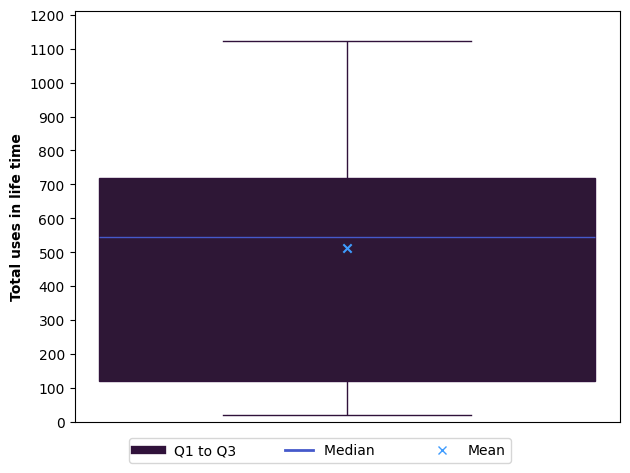

In [75]:
color_Q1_Q3 = 0
color_median = 1
color_mean = 2
plot_label = 'Total uses in life time'
save_name = 'alu_container'
leg_size = 0.7
y_min = 0
y_max = 1210
ystep = 100
life_time = 10

path_box_plot = r"C:\Users\ruw\Desktop\RA\Single-use-vs-multi-use-in-health-care\Single-use-vs-multi-use-in-health-care\Data\container.xlsx"

plot_structure = [color_Q1_Q3, color_median, color_mean, plot_label, save_name, leg_size, y_min, y_max, ystep, life_time]

bp.box_plot(path_box_plot, inputs, plot_structure)